# Table Docs

This notebook provides a full set of examples showing heavylight.Table features.

In [2]:
from heavylight import Table
import numpy as np
import pandas as pd
import seaborn as sns

## Example 1: Simple Table

Tables can be created directly from pandas dataframes, or from csv files or excel spreadsheet.

Here we create a dataframe table, with key `x` being an integer key, and floating point values.

In [3]:
df1 = pd.DataFrame({
    'x|int': np.arange(20, 51),
})
df1['value|float'] = df1['x|int'] * 0.04 - 0.03
df1.tail()

,x|int,value|float
26,46,1.81
27,47,1.85
28,48,1.89
29,49,1.93
30,50,1.97


We can pass the dataframe in as the contructor to the class.

In [4]:
tab1 = Table(df1)

Querying a single value from the table just involves using array `[]` notation.

In [5]:
print(tab1[20])
print(tab1[20] - (20*0.04 - 0.03))

0.77
0.0


We can query multiple results by passing in a numpy array.  (if not a numpy array then convert first using `np.array`).

In [6]:
x1s = np.array([30, 20, 20, 50])
tab1[x1s]

array([1.17, 0.77, 0.77, 1.97])

## Example 2: String key

In [7]:
df2 = pd.DataFrame(
    {
        'x|str':['A', 'B', 'C'],
        'value|float': [0.3, 0.5, 0.9]
    }
)
df2

,x|str,value|float
0,A,0.3
1,B,0.5
2,C,0.9


In [8]:
tab2 = Table(df2)

In [9]:
tab2['A']

0.3

In [10]:
tab2['B']

0.5

In [11]:
tab2['AB'] # this should fail?!  Probably because AB is between A and B?  String keys need mapped to unique integers?

0.5

In [12]:
x2s = np.array(['A', 'A', 'C', 'B'])
tab2[x2s]

array([0.3, 0.3, 0.9, 0.5])

In [13]:
# Error if not there (caveat, due to searchsorted intermediate values might not return an error)
try:
    tab2['Z']
except Exception as err:
    print(repr(err))

IndexError('index 3 is out of bounds for axis 0 with size 3')


## Example 3: Banded Key

Often we may want to get a value for a range of inputs, for example if a fee applies to a range of fund values, or reinsurance rates are set by sum assured bands.

We can assign one or more band tables using the `|band` suffix, which specifies the upper bound for that band.

The interval is open on the left, closed on the right, i.e. $(B-1, B]$ with the first band being $[-\infty, B]$.  For an open ended final band, `np.inf` or a significantly high number should be chosen.

In [14]:
df3 = pd.DataFrame({
    'age_to|band': np.array([20, 30, 40, 60, 90, 130, np.inf]),
})
df3['value|str'] = df3['age_to|band'].map(lambda i: f'age_to_{i:03.0f}')
df3

,age_to|band,value|str
0,20.0,age_to_020
1,30.0,age_to_030
2,40.0,age_to_040
3,60.0,age_to_060
4,90.0,age_to_090
5,130.0,age_to_130
6,inf,age_to_inf


Create a table (again, passing the dataframe in is sufficient)

In [15]:
tab3 = Table(df3)

We can look up any floating point value, and it will return the band it is contained within:

In [16]:
tab3[18.5]

'age_to_020'

In [17]:
tab3[20]

'age_to_020'

In [18]:
tab3[20.00000001]

'age_to_030'

In [19]:
# there is no lower bound (generally because the bands will be currency)
tab3[-5]

'age_to_020'

In [20]:
# there is an upper bound, and will error if over this
try:
    print(tab3[131])
except Exception as err:
    print(repr(err))

age_to_inf


In [21]:
x3s = np.linspace(35, 45, 14)
pd.DataFrame({'x3s':x3s, 'result':tab3[x3s]})

,x3s,result
0,35.000000,age_to_040
1,35.769231,age_to_040
2,36.538462,age_to_040
3,37.307692,age_to_040
4,38.076923,age_to_040
5,38.846154,age_to_040
6,39.615385,age_to_040
7,40.384615,age_to_060
8,41.153846,age_to_060
9,41.923077,age_to_060


## Example 4: Bounded Integer

If we are dealing with integer keys, sometimes we want the last key to be used for all higher values, for example in a mortality table with a 5 year select period, for durations 5+ we want to use the 5 year duration rate.  This can be accomplished by specifying the key column as a bounded integer: `|int_bound`.  When specified, this applies both on the lower and upper bounds.

In [22]:
df4 = pd.DataFrame({
    'term|int_bound': [5, 6, 7, 8, 9, 10],
    'rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
})
df4

,term|int_bound,rate
0,5,0.05
1,6,0.06
2,7,0.07
3,8,0.08
4,9,0.09
5,10,0.10


In [23]:
tab4 = Table(df4)

<Axes: >

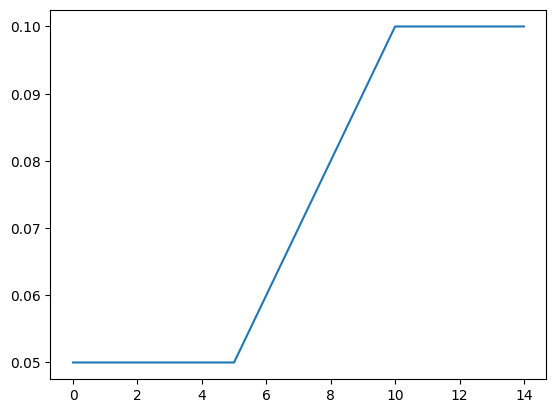

In [24]:
x4s = np.arange(0, 15)
sns.lineplot(x=x4s, y=tab4[x4s], markers=True)

## Example 5: Two keys are better than one

Tables often have multiple dimensions, e.g. Income Protection recovery rates vary by age, duration etc.  `Table` deals with these the same way as the one dimensional case.

In [25]:
df5 = pd.DataFrame({
    'age|int_bound': np.tile(np.arange(20, 41), 5),
    'dur|int_bound': np.repeat(np.arange(1, 6), (41-20))
})
df5['values'] = df5['age|int_bound'] * 0.01 + 1.32 ** df5['dur|int_bound']
df5

,age|int_bound,dur|int_bound,values
0,20,1,1.520000
1,21,1,1.530000
2,22,1,1.540000
3,23,1,1.550000
4,24,1,1.560000
...,...,...,...
100,36,5,4.367464
101,37,5,4.377464
102,38,5,4.387464
103,39,5,4.397464


In [26]:
tab5 = Table(df5)

We can lookup the keys by passing in comma separated values

In [27]:
tab5[104, 40]

4.4074642432000015

Like the one dimensional case, we can pass in numpy arrays of values to each key, to obtain an array of results:

In [28]:
x5_age = np.array([20, 20, 40, 30, 0, 9999])
x5_dur = np.array([1, 2, 3, 5, -2, 9999])
tab5[x5_age, x5_dur]

array([1.52      , 1.9424    , 2.699968  , 4.30746424, 1.52      ,
       4.40746424])

## Example 6: Error: Tables need to be complete

If using more than one dimension, the table needs to be complete, i.e. len(key 1) x len(key 2) x len(key 3) == len(table).

This is tested at table construction time.



In [29]:
df6 = pd.DataFrame({
    'k1|int': [1,2,3,4, 1,2],
    'k2|str': list('AAAABB'),
    'values': [1, 2, 3, 4, 11, 22]
})
df6

,k1|int,k2|str,values
0,1,A,1
1,2,A,2
2,3,A,3
3,4,A,4
4,1,B,11
5,2,B,22


In [30]:
# This will trigger an assertion error (to fix:should raise a proper Exception)

try:
    tab6 = Table(df6)
except Exception as err:
    print(repr(err))

ValueError('Input `df` is not rectangular, expected_rows=8 != len(self.values)=6')


## Example 7: External tables (CSO)

In [44]:
csv7_src = 'example_tables/2017_loaded_CSO_mortality_rates_heavytable.csv'
df7 = pd.read_csv(csv7_src)
df7 = df7.drop(columns=['Age|int'])
df7

,IssueAge|int,Duration|int,Underwriting|str,Sex|str,vals
0,18,1,NS_P,Female,0.00033
1,18,2,NS_P,Female,0.00033
2,18,3,NS_P,Female,0.00033
3,18,4,NS_P,Female,0.00033
4,18,5,NS_P,Female,0.00033
...,...,...,...,...,...
53555,118,2,S_R,Male,0.94856
53556,118,3,S_R,Male,1.00000
53557,119,1,S_R,Male,0.94856
53558,119,2,S_R,Male,1.00000


In [45]:
len(df7['IssueAge|int'].unique()) * len(df7['Duration|int'].unique()) * len(df7['Underwriting|str'].unique()) * len(df7['Sex|str'].unique())

106090

In [46]:
for col in df7:
    print(df7[col].value_counts())

IssueAge|int
18     1030
19     1020
20     1010
21     1000
22      990
       ... 
116      50
117      40
118      30
119      20
120      10
Name: count, Length: 103, dtype: int64
Duration|int
1      1030
2      1020
3      1010
4      1000
5       990
       ... 
99       50
100      40
101      30
102      20
103      10
Name: count, Length: 103, dtype: int64
Underwriting|str
NS_P     10712
NS_R     10712
NS_SP    10712
S_P      10712
S_R      10712
Name: count, dtype: int64
Sex|str
Female    26780
Male      26780
Name: count, dtype: int64
vals
1.00000    1030
0.94856     510
0.94780     510
0.89977     505
0.89833     505
           ... 
0.02581       1
0.02956       1
0.01209       1
0.02202       1
0.17419       1
Name: count, Length: 4579, dtype: int64


### We need to make the dataframe rectangular, i.e. Age|int and Duration|int need populated with the missing values

The `rectify` method in Table can do this.

In [47]:
tab7 = Table(Table.rectify(df7))

In [48]:
# run some tests on this

df7_test = df7.sample(n=100_000, replace=True)
df7_test

,IssueAge|int,Duration|int,Underwriting|str,Sex|str,vals
34195,40,25,S_P,Female,0.01299
5669,21,8,NS_P,Male,0.00051
14683,68,47,NS_R,Female,0.72494
36976,89,13,S_P,Female,0.35742
27879,29,22,NS_SP,Male,0.00163
...,...,...,...,...,...
28284,33,65,NS_SP,Male,0.28269
41572,70,51,S_P,Male,1.00000
10090,86,9,NS_P,Male,0.22817
17779,36,11,NS_R,Male,0.00118


In [51]:
df7_test['val_from_tab7'] = tab7[
     df7_test['IssueAge|int'].values,
     df7_test['Duration|int'].values,
     df7_test['Underwriting|str'].values,
     df7_test['Sex|str'].values]
df7_test

,IssueAge|int,Duration|int,Underwriting|str,Sex|str,vals,val_from_tab7
34195,40,25,S_P,Female,0.01299,0.01299
5669,21,8,NS_P,Male,0.00051,0.00051
14683,68,47,NS_R,Female,0.72494,0.72494
36976,89,13,S_P,Female,0.35742,0.35742
27879,29,22,NS_SP,Male,0.00163,0.00163
...,...,...,...,...,...,...
28284,33,65,NS_SP,Male,0.28269,0.28269
41572,70,51,S_P,Male,1.00000,1.00000
10090,86,9,NS_P,Male,0.22817,0.22817
17779,36,11,NS_R,Male,0.00118,0.00118


In [52]:
np.allclose(df7_test['vals'], df7_test['val_from_tab7'])

True

We can also specify a different fill value for missing values, using `fill`.  The default is `np.nan`

In [53]:
tab7b = Table(Table.rectify(df7, fill=-1))   # np.nan is the default fill

In [55]:
tab7b[
     df7_test['IssueAge|int'].values,
     df7_test['Duration|int'].values,
     df7_test['Underwriting|str'].values,
     df7_test['Sex|str'].values
]

array([1.2990e-02, 5.1000e-04, 7.2494e-01, ..., 2.2817e-01, 1.1800e-03,
       7.2200e-03])

In [59]:
tab7b[2, 2, 'NS_P', 'Female']  # This should fail, but because the value exists for a different key, it passes.

0.45219

In [60]:
df7['IssueAge|int'].describe()

count    53560.00000
mean        52.00000
std         24.39285
min         18.00000
25%         31.00000
50%         48.00000
75%         69.00000
max        120.00000
Name: IssueAge|int, dtype: float64